In [1]:
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from prettytable import PrettyTable
import sklearn
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

/home/pritish/anaconda3/envs/jami/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_pickle('merged_train.pkl')
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [3]:
print("*"*45)
print("\n Data Shape : {} \n".format(df.shape))
print("*"*45)

*********************************************

 Data Shape : (590540, 434) 

*********************************************


In [4]:
def missing_values_table(df):
    mis_val = df.isnull().sum()

    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    return mis_val_table_ren_columns

In [5]:
print("columns with null values: ")
print(list(df.columns[df.isnull().any()]))
print('===========================================')

missing_values = missing_values_table(df)
missing_values[:].style.background_gradient(cmap='Reds')

columns with null values: 
['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102',

,Missing Values,% of Total Values
id_24,585793,99.200000
id_25,585408,99.100000
id_07,585385,99.100000
id_08,585385,99.100000
id_21,585381,99.100000
id_26,585377,99.100000
id_27,585371,99.100000
id_23,585371,99.100000
id_22,585371,99.100000
dist2,552913,93.600000


## Utility Functions
<br>

In [6]:
def cat_num_features(df):
    
    '''
        Utility Function to get the names of Categorical Features and 
        Numerical Features of the given Dataset.
    '''
    
    catf = []
    numf = []
    
    catf = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', \
            'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', \
            'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', \
            'DeviceType', 'DeviceInfo']
    catf+=['id_'+str(i) for i in range(12,39)]


    catf = [feature for feature in catf if feature in df.columns.values]
    numf = [feature for feature in df.columns if feature not in catf and not feature == 'isFraud']
    
    return (catf, numf)  

In [7]:
def label_encode(X_train, X_test, catf):
  
  '''
    Utility Function to Encode Categorical Features.
  '''

  for f in catf:
    
    X_train[f] = X_train[f].astype(str)
    X_test[f] = X_test[f].astype(str)
    
    le = LabelEncoder()
    le.fit(X_train[f])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_train[f] = le.transform(X_train[f])
    

    X_test[f] = [-1 if mapping.get(v, -1)==-1 else mapping[v] for v in X_test[f].values ]

  return (X_train, X_test)

In [8]:
def normalize(X_train, X_test):
    '''
        Utility Function to scale the values of the Train, CV and Test Datasets between 0 and 1.
    '''
    
    for f in X_train.columns:

        min_val = X_train[f].min()
        max_val = X_train[f].max()
        
        X_train[f] = (X_train[f]-min_val)/(max_val-min_val)
        X_test[f] = (X_test[f]-min_val)/(max_val-min_val)
        
    return (X_train, X_test)

In [9]:
def predict_and_save(prediction, name):
    
    '''
        Utility Function to save the test data predictions locally.
    '''

    df = pd.DataFrame({'TransactionID':test_ids.reshape(-1), 'isFraud':prediction.reshape(-1)})
    df = df.sort_values('TransactionID')
    df.to_csv(name, index=False)

In [10]:
def tpr_fpr_threshold_auc(Y, proba):
    
    '''
        Utility Function to return fpr, tpr, threshold and roc_auc.
    '''
    
    fpr, tpr, threshold = sklearn.metrics.roc_curve(Y, proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    return (fpr, tpr, threshold, roc_auc)

In [11]:
def train_test_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc):

    '''
        Utility Function to Draw ROC-AUC Curves for Train and Validation Datasets.
    '''
    
    plt.title('\nReceiver Operating Characteristic\n')
    plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
    plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

In [12]:
def best_threshold(threshold,tpr,fpr):
    
    '''
        Utility Function to return the best threshold value based on the TPR and FPR values.
    '''
    
    return threshold[np.argmax(tpr*(1-fpr))];


def class_label(best_thr, pred_score):
    
    '''
        Utility Function to return the class label based on the chosen threshold.
    '''
    return np.where(pred_score>best_thr,1,0);

In [13]:
def draw_confusion_matrix(Y, predicted):
    
    '''
        Utility Function to draw Confusion Matrix.
    '''

    cv_cm = confusion_matrix(Y, predicted)
    sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Oranges', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
    plt.title('\nConfusion  Matrix\n')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

## Data Preparation
<br>

### Splitting the Dataset
<br>

In [14]:
X = df.drop(['isFraud','TransactionID'], axis=1)
y = df['isFraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
del df
print('Train shape:',X_train.shape)
print('Test shape:',X_test.shape)

Train shape: (442905, 432)
Test shape: (147635, 432)


In [16]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Test Data Shape : {} \n".format(X_test.shape))
print("*"*45)

*********************************************

 Train Data Shape : (442905, 432) 


 Test Data Shape : (147635, 432) 

*********************************************


In [17]:
catf, numf = cat_num_features(X_train)
categorical_feature_indices = [X_train.columns.get_loc(f) for f in catf]

#### Label Encoding Categorical Features

In [18]:
X_train[catf] = X_train[catf].fillna('missing')
X_test[catf] = X_test[catf].fillna('missing')


X_train, X_test = label_encode(X_train, X_test, catf)

In [19]:
X_train1 = X_train.fillna(-999)
X_test1 = X_test.fillna(-999)
X_train1, X_test1 = normalize(X_train1, X_test1)

del X_train, X_test

In [20]:
train1 = X_train1
train1['isFraud'] = y_train

test1 = X_test1

del X_train1, X_test1

In [21]:
y_train = train1.pop('isFraud')

X_train1 = train1
X_test1 = test1 


del train1

In [22]:
print("*"*60)
print("\n Train Dataset Set1 Shape : {} \n".format(X_train1.shape))
print("\n Test Dataset Set1 Shape : {} \n".format(X_test1.shape))
print("*"*60)

************************************************************

 Train Dataset Set1 Shape : (442905, 432) 


 Test Dataset Set1 Shape : (147635, 432) 

************************************************************


## Base Line Models
<br>

<br>

### 1. Naive Bayes

<br>

In [23]:
nb = GaussianNB(priors=[0.5,0.5]) 
nb.fit(X_train1, y_train)

GaussianNB(priors=[0.5, 0.5])

In [24]:
nb_train_proba = nb.predict_proba(X_train1)[:,1]
nb_test_proba = nb.predict_proba(X_test1)[:,1]

In [25]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, nb_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, nb_test_proba)

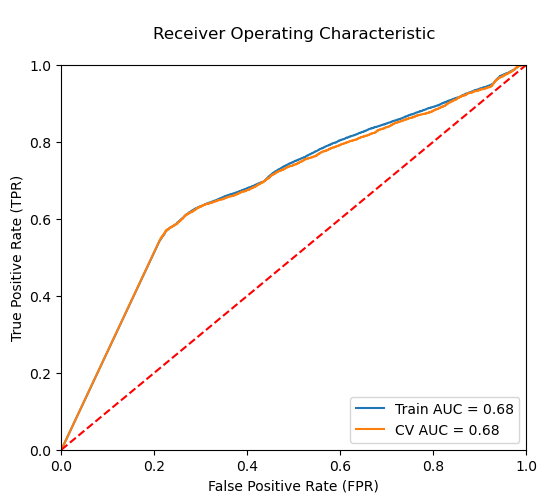

In [26]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

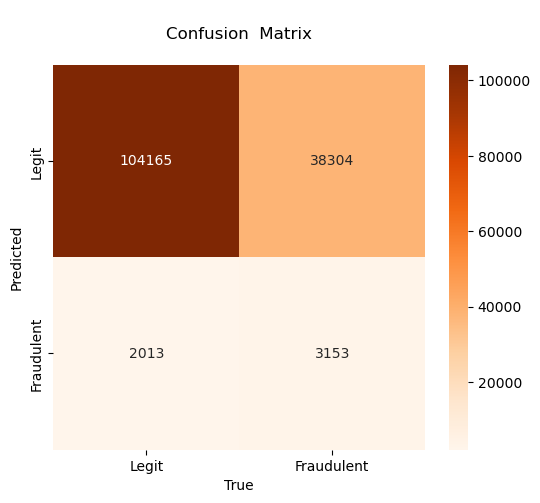

In [27]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, nb_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [28]:
y_pred=nb.predict(X_test1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.79      0.87    142469
           1       0.09      0.55      0.15      5166

    accuracy                           0.78    147635
   macro avg       0.53      0.67      0.51    147635
weighted avg       0.95      0.78      0.85    147635



In [29]:
roc_auc_score(y_test, y_pred)

0.6677576179085621

<br>

### 2. Logistic Regression

<br>

In [30]:
lr = LogisticRegression(n_jobs = -1, class_weight = 'balanced', solver = 'saga', random_state = 3, max_iter=1000) 
lr.fit(X_train1, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=3, solver='saga')

In [31]:
lr_train_proba = lr.predict_proba(X_train1)[:,1]
lr_test_proba = lr.predict_proba(X_test1)[:,1]

In [32]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, lr_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, lr_test_proba)

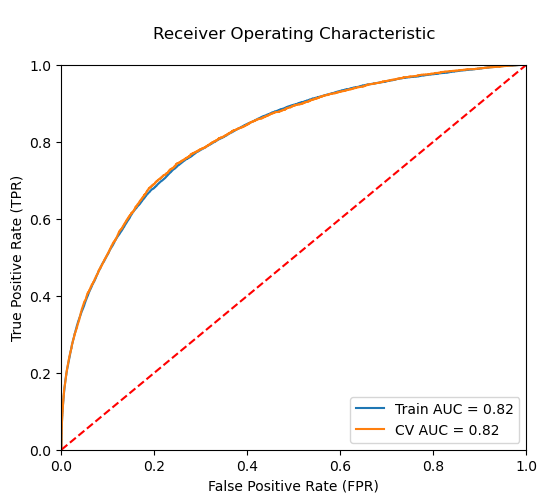

In [33]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

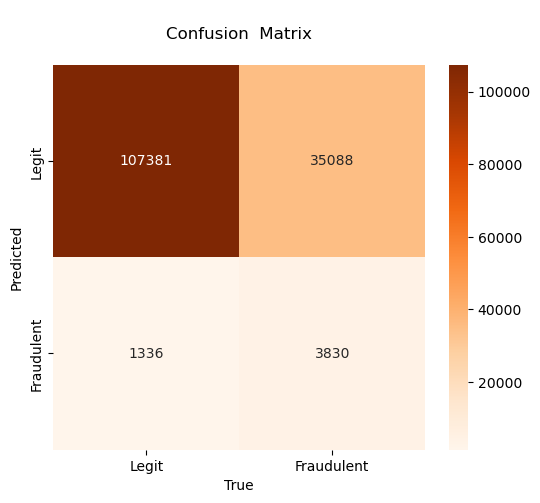

In [34]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, lr_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [36]:
y_pred=lr.predict(X_test1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93    142469
           1       0.15      0.54      0.23      5166

    accuracy                           0.87    147635
   macro avg       0.56      0.71      0.58    147635
weighted avg       0.95      0.87      0.91    147635



In [37]:
roc_auc_score(y_test, y_pred)

0.7136552547145935

<br>

### 3. Decision Tree

<br>

In [38]:
dt =  DecisionTreeClassifier(random_state=3, class_weight='balanced')
dt.fit(X_train1, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=3)

In [39]:
dt_train_proba = dt.predict_proba(X_train1)[:,1]
dt_test_proba = dt.predict_proba(X_test1)[:,1]

In [40]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, dt_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, dt_test_proba)

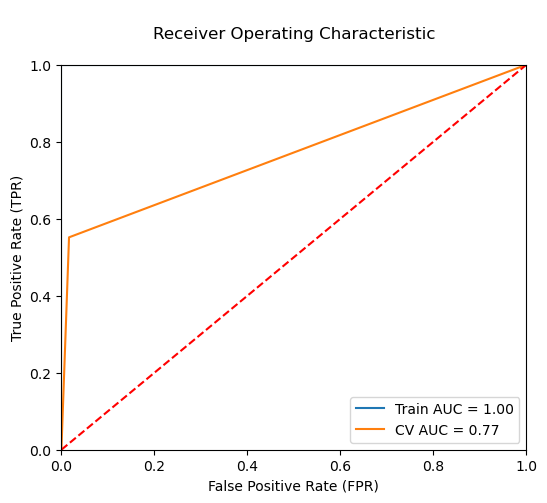

In [41]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

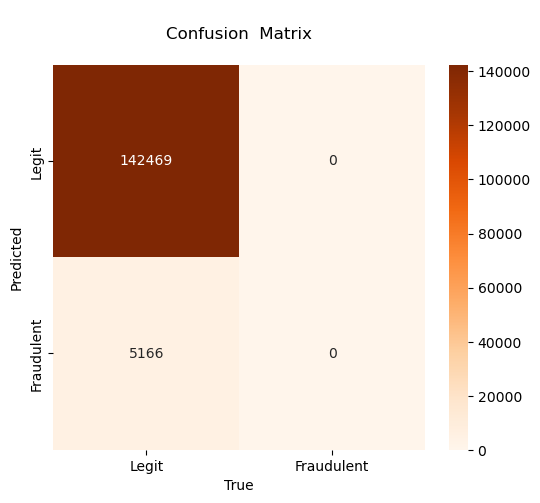

In [42]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, dt_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [43]:
# y_pred=dt.predict(X_test1)
# print(classification_report(y_test, y_pred))
print(classification_report(y_test, dt_test_proba))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    142469
           1       0.55      0.55      0.55      5166

    accuracy                           0.97    147635
   macro avg       0.77      0.77      0.77    147635
weighted avg       0.97      0.97      0.97    147635



In [44]:
roc_auc_score(y_test, dt_test_proba)

0.7676367503515181

<br>

### 4. Random Forest

<br>

In [45]:
rf =  RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', random_state = 3)
rf.fit(X_train1, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=3)

In [46]:
rf_train_proba = rf.predict_proba(X_train1)[:,1]
rf_test_proba = rf.predict_proba(X_test1)[:,1]

In [47]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, rf_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, rf_test_proba)

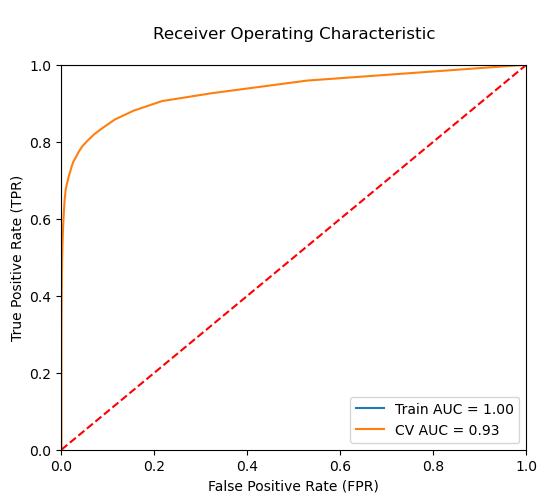

In [48]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

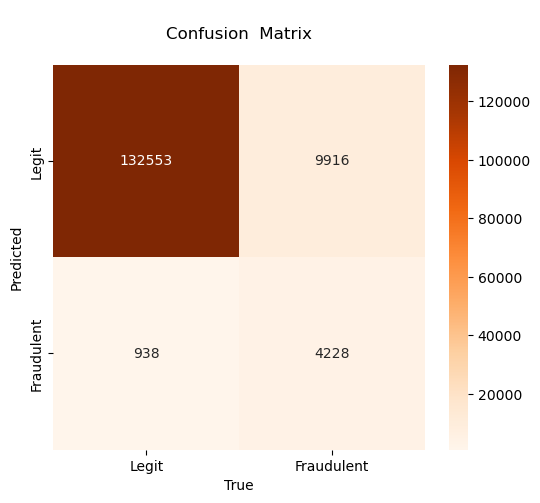

In [49]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, rf_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [51]:
y_pred=rf.predict(X_test1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142469
           1       0.95      0.42      0.58      5166

    accuracy                           0.98    147635
   macro avg       0.97      0.71      0.78    147635
weighted avg       0.98      0.98      0.97    147635



In [52]:
roc_auc_score(y_test, y_pred)

0.7085728883370698

<br>

### 6. Gradient Boosted Decision Tree (XGBoost)

<br>

In [53]:
weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [54]:
import tensorflow as tf
tf.test.is_built_with_cuda()

2022-11-24 21:07:59.557105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


False

In [55]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [56]:
from xgboost import XGBClassifier
xgb =  XGBClassifier(scale_pos_weight = weight, objective='binary:logistic', eval_metric = 'auc', 
                         random_state = 3, tree_method = 'hist')
xgb.fit(X_train1, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=27.58004775117765,
              subsample=1, tree_method='hist', validate_parameters=1,
              verbosity=None)

In [57]:
xgb_train_proba = xgb.predict_proba(X_train1)[:,1]
xgb_test_proba = xgb.predict_proba(X_test1)[:,1]

In [58]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, xgb_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, xgb_test_proba)

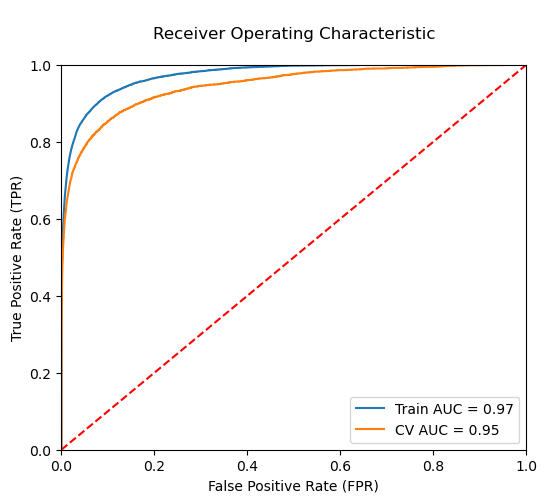

In [59]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

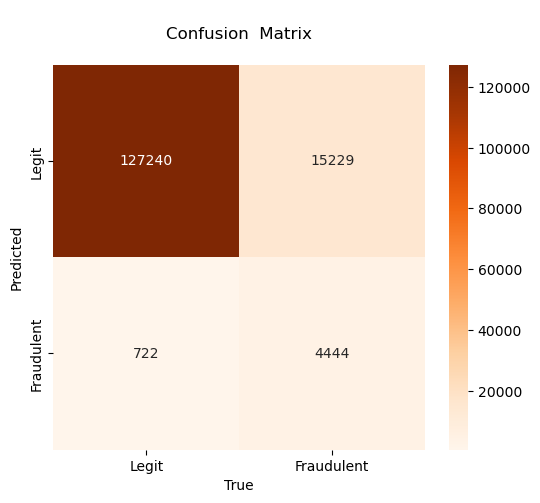

In [60]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, xgb_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [62]:
y_pred=xgb.predict(X_test1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    142469
           1       0.29      0.82      0.43      5166

    accuracy                           0.92    147635
   macro avg       0.64      0.87      0.69    147635
weighted avg       0.97      0.92      0.94    147635



In [63]:
roc_auc_score(y_test, y_pred)

0.8746837236717964

### LGBMClassifier

In [64]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(class_weight = 'balanced', random_state = 3,n_jobs = -1)
lgbm.fit(X_train1, y_train)

LGBMClassifier(class_weight='balanced', random_state=3)

In [65]:
lgbm_train_proba = lgbm.predict_proba(X_train1)[:,1]
lgbm_test_proba = lgbm.predict_proba(X_test1)[:,1]

In [66]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, lgbm_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, lgbm_test_proba)

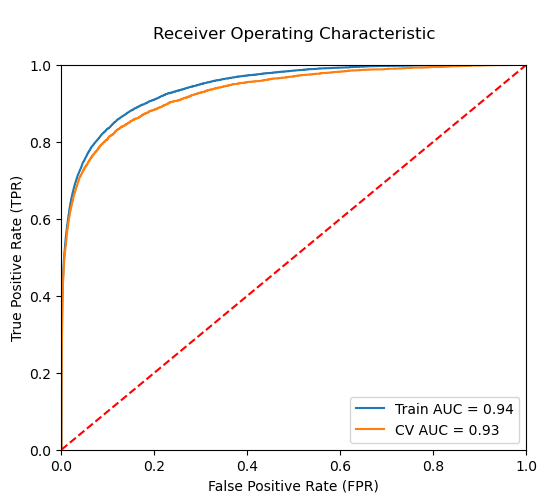

In [67]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

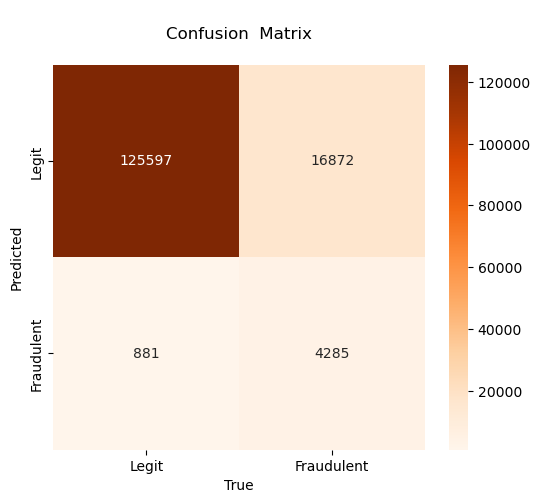

In [68]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, lgbm_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [70]:
y_pred=lgbm.predict(X_test1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94    142469
           1       0.21      0.82      0.34      5166

    accuracy                           0.89    147635
   macro avg       0.60      0.85      0.64    147635
weighted avg       0.97      0.89      0.92    147635



In [71]:
roc_auc_score(y_test, y_pred)

0.8543986586080125

### CatBoostClassifier

In [72]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(scale_pos_weight = weight,random_state = 3,eval_metric = 'AUC')
cat.fit(X_train1, y_train)

Learning rate set to 0.138966
0:	total: 138ms	remaining: 2m 17s
1:	total: 193ms	remaining: 1m 36s
2:	total: 250ms	remaining: 1m 23s
3:	total: 306ms	remaining: 1m 16s
4:	total: 372ms	remaining: 1m 14s
5:	total: 434ms	remaining: 1m 11s
6:	total: 490ms	remaining: 1m 9s
7:	total: 553ms	remaining: 1m 8s
8:	total: 621ms	remaining: 1m 8s
9:	total: 677ms	remaining: 1m 7s
10:	total: 743ms	remaining: 1m 6s
11:	total: 807ms	remaining: 1m 6s
12:	total: 858ms	remaining: 1m 5s
13:	total: 920ms	remaining: 1m 4s
14:	total: 984ms	remaining: 1m 4s
15:	total: 1.04s	remaining: 1m 4s
16:	total: 1.1s	remaining: 1m 3s
17:	total: 1.16s	remaining: 1m 3s
18:	total: 1.23s	remaining: 1m 3s
19:	total: 1.28s	remaining: 1m 2s
20:	total: 1.34s	remaining: 1m 2s
21:	total: 1.41s	remaining: 1m 2s
22:	total: 1.46s	remaining: 1m 2s
23:	total: 1.55s	remaining: 1m 2s
24:	total: 1.61s	remaining: 1m 2s
25:	total: 1.68s	remaining: 1m 2s
26:	total: 1.74s	remaining: 1m 2s
27:	total: 1.81s	remaining: 1m 3s
28:	total: 1.88s	remain

241:	total: 15.5s	remaining: 48.5s
242:	total: 15.5s	remaining: 48.4s
243:	total: 15.6s	remaining: 48.3s
244:	total: 15.7s	remaining: 48.3s
245:	total: 15.7s	remaining: 48.2s
246:	total: 15.8s	remaining: 48.2s
247:	total: 15.9s	remaining: 48.1s
248:	total: 15.9s	remaining: 48s
249:	total: 16s	remaining: 48s
250:	total: 16s	remaining: 47.9s
251:	total: 16.1s	remaining: 47.8s
252:	total: 16.2s	remaining: 47.8s
253:	total: 16.2s	remaining: 47.7s
254:	total: 16.3s	remaining: 47.7s
255:	total: 16.4s	remaining: 47.6s
256:	total: 16.4s	remaining: 47.6s
257:	total: 16.5s	remaining: 47.5s
258:	total: 16.6s	remaining: 47.4s
259:	total: 16.6s	remaining: 47.3s
260:	total: 16.7s	remaining: 47.3s
261:	total: 16.7s	remaining: 47.2s
262:	total: 16.8s	remaining: 47.1s
263:	total: 16.9s	remaining: 47.1s
264:	total: 16.9s	remaining: 47s
265:	total: 17s	remaining: 46.9s
266:	total: 17.1s	remaining: 46.8s
267:	total: 17.1s	remaining: 46.8s
268:	total: 17.2s	remaining: 46.7s
269:	total: 17.3s	remaining: 46.

480:	total: 31.1s	remaining: 33.5s
481:	total: 31.1s	remaining: 33.5s
482:	total: 31.2s	remaining: 33.4s
483:	total: 31.3s	remaining: 33.3s
484:	total: 31.3s	remaining: 33.3s
485:	total: 31.4s	remaining: 33.2s
486:	total: 31.4s	remaining: 33.1s
487:	total: 31.5s	remaining: 33.1s
488:	total: 31.6s	remaining: 33s
489:	total: 31.6s	remaining: 32.9s
490:	total: 31.7s	remaining: 32.9s
491:	total: 31.8s	remaining: 32.8s
492:	total: 31.8s	remaining: 32.7s
493:	total: 31.9s	remaining: 32.7s
494:	total: 32s	remaining: 32.6s
495:	total: 32.1s	remaining: 32.6s
496:	total: 32.1s	remaining: 32.5s
497:	total: 32.2s	remaining: 32.4s
498:	total: 32.2s	remaining: 32.4s
499:	total: 32.3s	remaining: 32.3s
500:	total: 32.4s	remaining: 32.2s
501:	total: 32.4s	remaining: 32.2s
502:	total: 32.5s	remaining: 32.1s
503:	total: 32.6s	remaining: 32s
504:	total: 32.6s	remaining: 32s
505:	total: 32.7s	remaining: 31.9s
506:	total: 32.8s	remaining: 31.8s
507:	total: 32.8s	remaining: 31.8s
508:	total: 32.9s	remaining:

718:	total: 46.4s	remaining: 18.2s
719:	total: 46.5s	remaining: 18.1s
720:	total: 46.6s	remaining: 18s
721:	total: 46.6s	remaining: 18s
722:	total: 46.7s	remaining: 17.9s
723:	total: 46.8s	remaining: 17.8s
724:	total: 46.8s	remaining: 17.8s
725:	total: 46.9s	remaining: 17.7s
726:	total: 46.9s	remaining: 17.6s
727:	total: 47s	remaining: 17.6s
728:	total: 47.1s	remaining: 17.5s
729:	total: 47.1s	remaining: 17.4s
730:	total: 47.2s	remaining: 17.4s
731:	total: 47.3s	remaining: 17.3s
732:	total: 47.3s	remaining: 17.2s
733:	total: 47.4s	remaining: 17.2s
734:	total: 47.5s	remaining: 17.1s
735:	total: 47.5s	remaining: 17s
736:	total: 47.6s	remaining: 17s
737:	total: 47.6s	remaining: 16.9s
738:	total: 47.7s	remaining: 16.9s
739:	total: 47.8s	remaining: 16.8s
740:	total: 47.8s	remaining: 16.7s
741:	total: 47.9s	remaining: 16.7s
742:	total: 48s	remaining: 16.6s
743:	total: 48s	remaining: 16.5s
744:	total: 48.1s	remaining: 16.5s
745:	total: 48.2s	remaining: 16.4s
746:	total: 48.2s	remaining: 16.3s

959:	total: 1m 1s	remaining: 2.57s
960:	total: 1m 1s	remaining: 2.5s
961:	total: 1m 1s	remaining: 2.44s
962:	total: 1m 1s	remaining: 2.38s
963:	total: 1m 1s	remaining: 2.31s
964:	total: 1m 1s	remaining: 2.25s
965:	total: 1m 2s	remaining: 2.18s
966:	total: 1m 2s	remaining: 2.12s
967:	total: 1m 2s	remaining: 2.05s
968:	total: 1m 2s	remaining: 1.99s
969:	total: 1m 2s	remaining: 1.93s
970:	total: 1m 2s	remaining: 1.86s
971:	total: 1m 2s	remaining: 1.8s
972:	total: 1m 2s	remaining: 1.73s
973:	total: 1m 2s	remaining: 1.67s
974:	total: 1m 2s	remaining: 1.6s
975:	total: 1m 2s	remaining: 1.54s
976:	total: 1m 2s	remaining: 1.47s
977:	total: 1m 2s	remaining: 1.41s
978:	total: 1m 2s	remaining: 1.34s
979:	total: 1m 2s	remaining: 1.28s
980:	total: 1m 2s	remaining: 1.22s
981:	total: 1m 2s	remaining: 1.15s
982:	total: 1m 3s	remaining: 1.09s
983:	total: 1m 3s	remaining: 1.02s
984:	total: 1m 3s	remaining: 961ms
985:	total: 1m 3s	remaining: 897ms
986:	total: 1m 3s	remaining: 833ms
987:	total: 1m 3s	remai

In [73]:
cat_train_proba = cat.predict_proba(X_train1)[:,1]
cat_test_proba = cat.predict_proba(X_test1)[:,1]

In [74]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, cat_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, cat_test_proba)

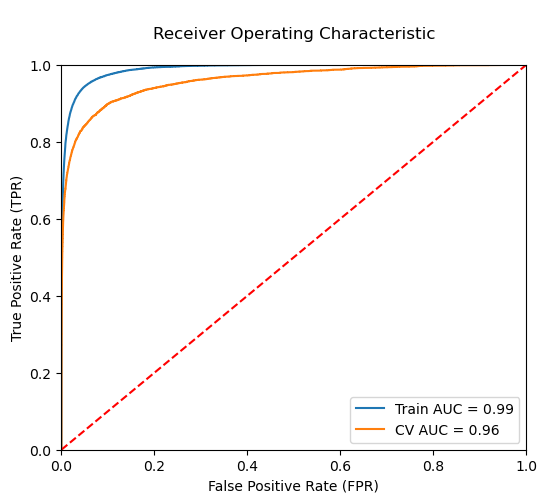

In [75]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

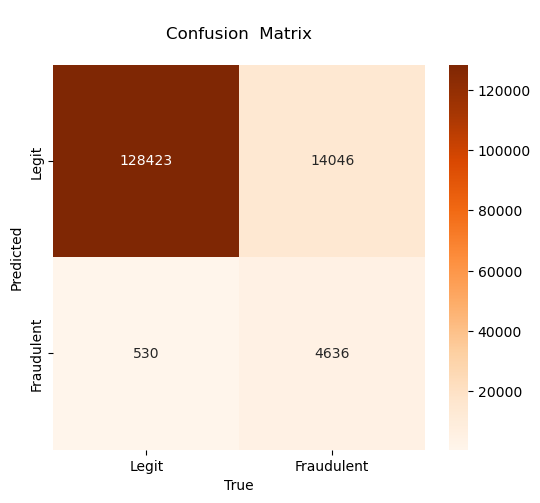

In [76]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, cat_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [78]:
y_pred=cat.predict(X_test1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    142469
           1       0.38      0.84      0.52      5166

    accuracy                           0.95    147635
   macro avg       0.68      0.90      0.75    147635
weighted avg       0.97      0.95      0.96    147635



In [79]:
roc_auc_score(y_test, y_pred)

0.8955919737993168

## Conclusion

From the above results, it is quite clear that the Catboost is working best for our problem. Hence, from now on we will be using Tree based Ensemble only and will try to optimize the data and models to get more better score.